In [1]:
import sys
sys.path.append('modules/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import scipy
sns.set_style('white')
from collections import defaultdict
import matplotlib
import general_figures as gn
import statsmodels.api as sm
from itertools import repeat
import matplotlib as mpl
# import fig1 as fig1
import math
import figures as fg

plt.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['pdf.fonttype'] = 42


# Data Loading and preprocessing

In [2]:
by_facs = {'Gal4':{'Full':3.31, 'Gal4AD': 3.341, 'Gcn4AD': 3.341},
          'Gcn4':{'Full': 3.27, 'Gal4AD': 3.32 , 'Gcn4AD': 3.32 },
          'Mig3':{'Full':3.26, 'Gal4AD':3.32 , 'Gcn4AD': 3.32 },
          'Yap1':{'Full':3.31, 'Gal4AD':3.3 , 'Gcn4AD':3.3 },
          'Msn2':{'Full':3.592, 'Gal4AD':3.62 , 'Gcn4AD':3.62 },}
by_facs_df = pd.DataFrame(by_facs)
directions = {'Msn2':['upregulated','upregulated','upregulated'],
            'Mig3':['downregulated','upregulated','upregulated'],
             'Yap1':['upregulated','upregulated','upregulated'],
            'Gal4':['upregulated','upregulated','upregulated'],
            'Gcn4':['upregulated','upregulated','upregulated']}

In [3]:

data = pd.read_pickle('data/averaged_chec_sumprom.gz')
TFS = ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3']

gp = pd.read_csv('data/geneinfo_params.csv', index_col=0)
aro_targets = np.array([1302,6541,4730,4729,2603,2604])
aro_targets = gp.iloc[aro_targets-1].index
data_check = data.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_waro = data
data_waro= data_waro.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_check = data.drop(aro_targets)

nuc_df = pd.read_csv('data/nucleosomes_df_perprom700bp.csv', index_col=0)
rna_nonlibs = pd.read_pickle('data/all_nonlibs_rna_samles.gz')
rna_libs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0)
facs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0).loc['facs']
by_rna = pd.read_csv('data/by_ultimate_61samples.csv', index_col=0)
by_rna_median = pd.DataFrame(by_rna.median(axis=1), columns=['BY_61_med'])

# Binning and filtering genes
all_dat = pd.concat([rna_libs.drop('facs'), rna_nonlibs], axis=1)
gene_thresh = 4.5
strain_thsh = 0.025
for_binnning = ((all_dat > gene_thresh).sum(axis=1) > all_dat.shape[1] * strain_thsh).values
bins = pd.qcut(by_rna_median.loc[for_binnning, 'BY_61_med'], q=10, labels=False, duplicates='drop')
data_waro = data_waro.loc[bins.drop('MNASE').index]


#Looking only on relevant genes
rna_nonlibs = rna_nonlibs.loc[bins.index]
rna_libs = rna_libs.loc[bins.index]
by_rna_median = by_rna_median.loc[bins.index]
rna_libs = pd.concat([rna_libs,pd.DataFrame(facs).transpose()], axis=0)
data_check = data_check.loc[bins.drop(['MNASE', 'SPL2', 'NAF1', 'ESBP6', 'SDH6']).index]

rna_libs.columns = [name.replace('Parent', 'nativeprom') for name in rna_libs.columns.values]
facs.index = [name.replace('Parent', 'nativeprom') for name in facs.index.values]
opn = pd.read_csv('data/external_datasets/opn_mine.csv', index_col=0)
opn.loc[np.isinf(opn.loc[:, 'opn_score']).values, 'opn_score'] = math.nan
opn = gn.prepare_opn(opn).loc[bins.index[:-1]]

In [4]:
thresh = 3
reload(gn)

binding_gcn4, rna_gcn4, top50_gcn4, fam_gcn4, wt_gcn4 = gn.get_data('Gcn4', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_gal4, rna_gal4, top50_gal4, fam_gal4, wt_gal4 = gn.get_data('Gal4', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_yap1, rna_yap1, top50_yap1, fam_yap1, wt_yap1 = gn.get_data('Yap1', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_msn2, rna_msn2, top50_msn2, fam_msn2, wt_msn2 = gn.get_data('Msn2', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_mig3, rna_mig3, top50_mig3, fam_mig3, wt_mig3 = gn.get_data('Mig3', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)



cmap = matplotlib.cm.get_cmap('YlOrRd')
tops = {'Msn2':top50_msn2, 'Gal4':top50_gal4, 'Gcn4':top50_gcn4, 'Mig3':top50_mig3, 'Yap1':top50_yap1}
individuals = {'Msn2':['TPS2', 'HOR7'], 'Gal4':['GAL10', 'GAL7'], 'Gcn4':['ARG56', 'CPA2'], 'Mig3':['HXT2', 'MIG2'], 'Yap1':['TRX2', 'YDL124W']}
wts = {'Msn2':wt_msn2, 'Gal4':wt_gal4, 'Gcn4':wt_gcn4, 'Mig3':wt_mig3, 'Yap1':wt_yap1}

# Figure 1 prep

In [5]:
reload(gn)
direct_targets = dict()
for tf in TFS:
    targets = tops[tf]
    curr_corrs = gn.load_corrs(tf)
    targets = set(targets).intersection(set(curr_corrs.loc[sm.stats.multipletests(curr_corrs.pval.values, method='fdr_bh')[0]].index))
    direct_targets[tf] = {'upregulated':curr_corrs.loc[targets].query('spearman>0').index.values,
                          'downregulated':curr_corrs.loc[targets].query('spearman<0').index.values}

C:\Users\vovam\AppData\Local\Temp\ipykernel_20584\381252857.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  direct_targets[tf] = {'upregulated':curr_corrs.loc[targets].query('spearman>0').index.values,
C:\Users\vovam\AppData\Local\Temp\ipykernel_20584\381252857.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  'downregulated':curr_corrs.loc[targets].query('spearman<0').index.values}
C:\Users\vovam\AppData\Local\Temp\ipykernel_20584\381252857.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  direct_targets[tf] = {'upregulated':curr_corrs.loc[targets].query('spearman>0').index.values,
C:\Users\vovam\AppData\Local\Temp\ipykernel_20584\381252857.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  'downregulated

In [6]:
all_tfs = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Yap1',
 'Mig3',
 'Dot6',
 'Abf1',
 'Crz1',
 'Gal4',
 'Gln3',
 'Reb1',
 'Msn2',
 'Met31',
 'Rpn4',
 'Sko1',
 'Ino2',
 'Gcn4',
 'Cst6']

lab_dat = data_waro.filter(regex='|'.join(all_tfs)).filter(regex='lab_data')
lab_dat = lab_dat.drop(lab_dat.filter(regex='dbd').columns, axis=1)
lab_dat = lab_dat.drop('Gal4_lab_data', axis=1)
lab_dat.loc[:, 'Gal4'] = data_check.filter(regex='^Gal4Full').filter(regex='erv')
lab_dat = lab_dat.rename({'Gcn4_lown_lab_data': 'Gcn4_lab_data'}, axis=1)

lab_dat.columns = [name.replace('_lab_data', '') for name in lab_dat.columns.values]


tfs_binding_deletions_tef = data_waro.filter(regex=''.join(['^{}|'.format(tf) for tf in TFS])[:-1]).filter(regex='deletions')
tfs_binding_deletions_tef = pd.concat([lab_dat.filter(regex=''.join(['^{}|'.format(tf) for tf in TFS])[:-1]), tfs_binding_deletions_tef], axis=1)


# Nongeneral funcs fig2

In [7]:

def fig1_scatters(genes, rna_libs, norm, cmap, by_facs_df, by_rna_median,tfs):
    '''
    Creates colored scatterplots of reporter genes for Figure 1A.
        Parameters:
            genes (list): list of reporter genes to plot
            rna_libs (pd.DataFrame): DataFrame of expression libraries
            norm (mp;.color.Normalize): function to normalize the colors in the plot
            by_facs_df (pd.DataFrame): DataFrame of fluoresence values of BY for normalization
        
        Returns:
            fig (matplotlib.Figure): Figure object for modification
            subfigs (matplotlib.Figure.subfigures): subfigure generated in script

    '''
    fig = plt.figure(figsize=(5,16))
    subfigs = fig.subfigures(1,len(genes))
    for k,gene in enumerate(genes):
        counter = 0
        ax = subfigs[k].subplots(len(tfs)*3,1, sharex=False, sharey=True)
        ax[0].set_title('{}\n{}'.format(tfs[k], gene))
        for b,tf in enumerate(tfs):
            for i, typ in enumerate(['Full', 'Gal4AD', 'Gcn4AD']):
                curr_libs = rna_libs.filter(regex='^'+tf).filter(regex=typ).sort_values(by='facs', axis=1)
                curr_gene = curr_libs.loc[gene]
                maxy = curr_gene[-5:].mean()
                miny = curr_gene[:5].mean()
                curr_gene = curr_gene-miny
                ax[counter].scatter(curr_libs.loc['facs'].sub(by_facs_df.loc[typ, tf]),
                                       curr_gene,s=20,c='gainsboro',alpha=0.8, edgecolors='k', linewidths=.3)
                ax[counter].set_facecolor(cmap(norm((maxy-miny)*by_rna_median.loc[gene].values[0])))

                ylims = ax[counter].get_ylim()
                xlims = ax[counter].get_xlim()
                ax[counter].text(xlims[1]-0.2, ylims[0], str(np.round(maxy-miny,1)))
                counter+=1
                
        for axes in [sub.axes for sub in subfigs]:
            for axi in axes:
                axi.set_yticklabels('')
                axi.set_xticklabels('')
        subfigs[0].axes[0].set_ylabel('Full')
        subfigs[0].axes[1].set_ylabel('Gal4AD')
        subfigs[0].axes[2].set_ylabel('Gcn4AD')

    return fig, subfigs

def return_gene_subset(to_subset, libs_list, stats_libs_list, t):
    '''
    Function to cubset the binding targets in set of TFs and return needed group

        Parameters:
            to_subset (str): keyword of the group to subset
            libs_list (list): list of DataFrames of rna_libraries
            stats_libs_list (list): list of DataFrames of statistics summary of rna libs
        Returns:
            fin_order (pd.Index): final order of the genes
            ordered_pass (pd.Index): order of genes that passed spearman rank thresholding
            ordered_not_pass (pd.Index): order of genes that did not pass spearman rank thresholding
    '''
    if to_subset == 'wt_targets':
        curr_targets = t.loc[:, 'wt_zscore_3'].loc[t.loc[:, 'wt_zscore_3'].values].index
        curr_df = stats_libs_list[0]
        curr_libs = libs_list[0]
        ordered_targets = curr_df.loc[curr_targets].sort_values(by='spearman', ascending=False)
        ordered_pass = ordered_targets.loc[ordered_targets.fdr_corr].index
        ordered_not_pass = curr_df.loc[curr_df.loc[curr_targets].drop(ordered_pass).index].index

        fin_order = pd.concat([curr_libs.loc[ordered_pass].sub(curr_libs.loc[ordered_pass].mean(axis=1), axis=0).sort_values(by=curr_libs.columns[-1], ascending=False),
                    curr_libs.loc[ordered_not_pass].sub(curr_libs.loc[ordered_not_pass].mean(axis=1), axis=0).sort_values(by=curr_libs.columns[-1], ascending=False)], axis=0).index
    elif to_subset == 'tef_full':
        curr_targets =  t[(t.full_tef_zscore_3*~t.wt_zscore_1*~t.dbdgal_tef_zscore_1*~t.dbdgcn_tef_zscore_1)].index
        curr_df = stats_libs_list[0]
        curr_libs = libs_list[0]
        ordered_targets = curr_df.loc[curr_targets].sort_values(by='spearman', ascending=False)
        ordered_pass = ordered_targets.loc[ordered_targets.fdr_corr].index
        ordered_not_pass = curr_df.loc[curr_df.loc[curr_targets].drop(ordered_pass).index].index

        fin_order = pd.concat([curr_libs.loc[ordered_pass].sub(curr_libs.loc[ordered_pass].mean(axis=1), axis=0).sort_values(by=curr_libs.columns[-1], ascending=False),
                    curr_libs.loc[ordered_not_pass].sub(curr_libs.loc[ordered_not_pass].mean(axis=1), axis=0).sort_values(by=curr_libs.columns[-1], ascending=False)], axis=0).index

    elif to_subset == 'tef_dbd':
        curr_targets =  t[(np.logical_or(t.dbdgal_tef_zscore_3, t.dbdgcn_tef_zscore_3)*~t.wt_zscore_1*~t.full_tef_zscore_1)].index
        curr_df1 = stats_libs_list[1]
        curr_df2 = stats_libs_list[2]
        curr_libs = libs_list[0]
        ordered_targets1 = curr_df1.loc[curr_targets].sort_values(by='spearman', ascending=False)
        ordered_targets2 = curr_df2.loc[curr_targets].sort_values(by='spearman', ascending=False)


        ordered_pass1 = ordered_targets1.loc[ordered_targets1.fdr_corr]
        ordered_pass2 = ordered_targets2.loc[ordered_targets2.fdr_corr]

        ordered_pass = pd.concat([ordered_pass1, ordered_pass2]).index.drop_duplicates()
        ordered_not_pass = curr_df1.loc[curr_df1.loc[curr_targets].drop(ordered_pass).index].index

        fin_order = pd.concat([curr_libs.loc[ordered_pass].sub(curr_libs.loc[ordered_pass].mean(axis=1), axis=0).sort_values(by=curr_libs.columns[-1], ascending=False),
                    curr_libs.loc[ordered_not_pass].sub(curr_libs.loc[ordered_not_pass].mean(axis=1), axis=0).sort_values(by=curr_libs.columns[-1], ascending=False)], axis=0).index
        
    return fin_order, ordered_pass, ordered_not_pass

def mod_df(dat, order):
    '''
    Function to place a value 'inorder' for the given set of genes
        Parameters:
            dat (pd.DataFrame): DataFrame of stats for given rna libs
            order (pd.Index): Index of genes that was defined as needed
        Returns:
            dat: Modified pd.DataFrame
    '''
    dat.loc[order, 'inorder'] = True
    dat = dat.fillna(False)
    return dat

def order_and_normalize(data, order, ordered_pass, ordered_not_pass):
    '''
    Funvtion to normalize the data on it's mean and move the values to starrt from 0 
    for libraries

        Parameters:
            data (pd.DataFrame): rna libs rna-seq data
            order (pd.Index/list): subset of genes needed in the right order
            order_pass (pd.Index/list): genes passed thresh
            ordered_not_pass (pd.Index/list): genes not passed thresh
        Returns:
            ord_normed (pd.DataFrame): normalized data
    '''
    ord_normed = pd.concat([data.loc[ordered_pass].sub(data.loc[ordered_pass].mean(axis=1), axis=0),
                data.loc[ordered_not_pass].sub(data.loc[ordered_not_pass].mean(axis=1), axis=0)], axis=0).loc[order]
    ord_normed = ord_normed.sub(ord_normed.iloc[:,:3].mean(axis=1), axis=0)
    return ord_normed

def htmp_libs(data, ax, cbar=False, label='', genes_passed=0):
    '''
    Function to plot the heatmap libs for Figures 1E and 2A

        Parameters:
            data (pd.DataFrame): normalized dataframe
            ax (matplotlib.axis): ax to plot the data on
            cbar (boolean): whether to plot the colobar on the axis
            label (str): the label of y axis of the heatmap
            genes_passed (int): the number of genes passed the spearman rnak corrected pvalue
        Returns:
            __
    '''
    sns.heatmap(data.rolling(window=3, center=True, axis=1).mean(), ax=ax,
                center=0, vmax=4, vmin=-4, cmap='RdYlBu_r', xticklabels=False,
                yticklabels=False, cbar=cbar, )
    ax.set_ylabel(label)
    ax.axhline(genes_passed, c='k', linestyle=':')
def create_data_forlibs_scatter(libs_list, bins, targets, all_targets, by_facs, tf):
    '''
    Function to create data for scatterplots in figs 1E 2A
        Parameters:
            libs_list (list): list of pd.DataFrames of rna libs expression
            data ordered by abundacne levels
            bins (pd.DataFrame): genomic bins created from BY data
            targets (pd.Index): genes that passed the spearman rank thresh in WT libs
            all_targets (pd.Index): all binding targets
            by_facs (dict): dictionary of abundance levels of BY strain from different experiments
            tf (str): Name of the TF
        Returns:
            maxv (int): number of maximal genes induced in the set of libraries
            pl_dict (dict): dictionary of data to plot
            fc_dict (dict): dictionary of fc data

    '''
    maxv = 0
    pl_dict = dict()
    fc_dict = dict()
    for i, k in enumerate(['Full', 'Gal4AD', 'Gcn4AD']):

        currlib = libs_list[i]
        low = currlib.iloc[:, :3].mean(axis=1)
        fc = currlib.sub(low, axis=0)
        fc_dict[k] = fc.loc[all_targets].iloc[:, -3:].mean().mean()
        mstd = fc.groupby(bins).std()
        mmean = fc.groupby(bins).mean()

        get_zs = lambda x: fc.loc[bins[bins == x].index].sub(mmean.loc[x]).div(mstd.loc[x])
        zs = pd.concat(map(get_zs, bins.unique()))

        target_zs = zs.loc[targets]

        c_to_draw = (np.abs(target_zs.rolling(window=3, axis=1, center=True).median()) > 2).sum()

        y = target_zs.sub(zs.mean(axis=1), axis=0).mean()
        y1 = y - y.iloc[:3].mean()
        y1 = y1.dropna()
        x = currlib.loc['facs', y1.index]- by_facs[tf][k]
        pl_dict[k] = (x, y1, c_to_draw)
        maxv = max(maxv, max(c_to_draw.values))
    return maxv, pl_dict, fc_dict
def get_corr_gene(facs, vector):
    '''
    Function to calculate spearman rank correlation values between vector of expression and facs
        Parameters:
            facs (list): list of orederd facs values
            vector (list): list of corresponding expression values
        Returns:
            res: output of scipy.stats.spearmanr
    '''
    res = scipy.stats.spearmanr(facs, vector)
    return (res[0], res[1])



# Supplementary

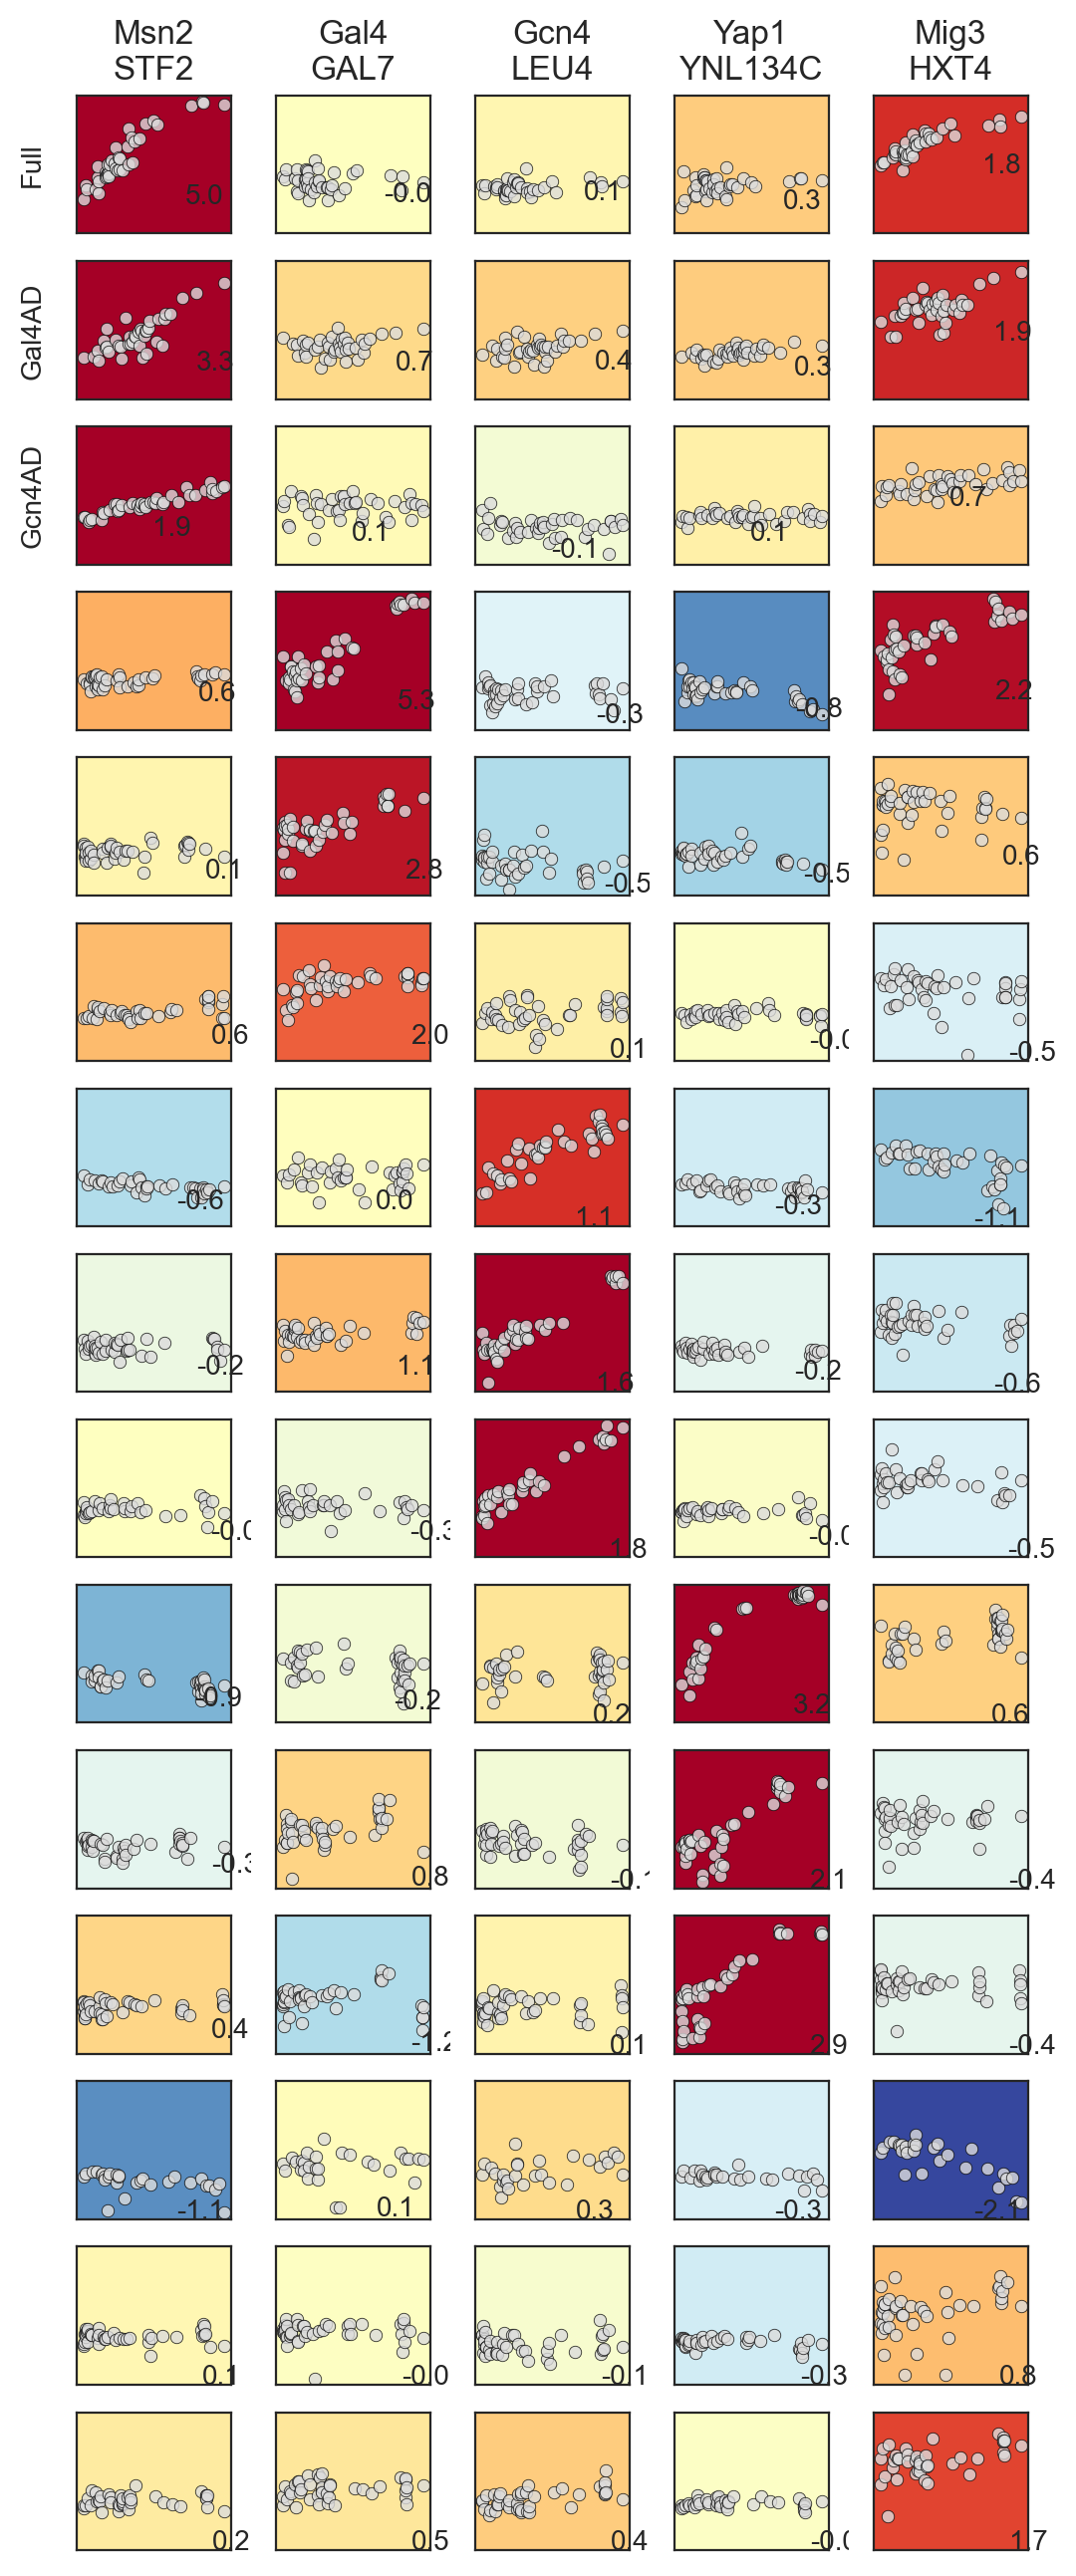

In [8]:
# reload(fig1)
cmap = sns.color_palette('RdYlBu_r', as_cmap=True)
# 'MTH1' for Mig?
genes_needed =['STF2', 'GAL7', 'LEU4', 'YNL134C', 'HXT4']
norm = mpl.colors.Normalize(vmin=-10, vmax=10)
tfs_to_plot = ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3']
fig, subfigs = fig1_scatters(genes_needed, rna_libs, norm, cmap, by_facs_df, by_rna_median, tfs_to_plot)
# fig.savefig('newtext_figs/fig2/reporters.pdf', bbox_inches = 'tight', transparent=False)

# Figure 2C + scatters for fig2f, supp

In [9]:
fc_big_d = dict()
effected_per_d = dict()
cmap = sns.color_palette('cubehelix', n_colors=3)
cbar=False
to_subset = ['wt_targets', 'tef_full', 'tef_dbd']

summary_stat_d = dict()
for tf in TFS:
    summary_stat_d[tf]= gn.prepare_data(tf, tfs_binding_deletions_tef, rna_libs, data_waro, bins)


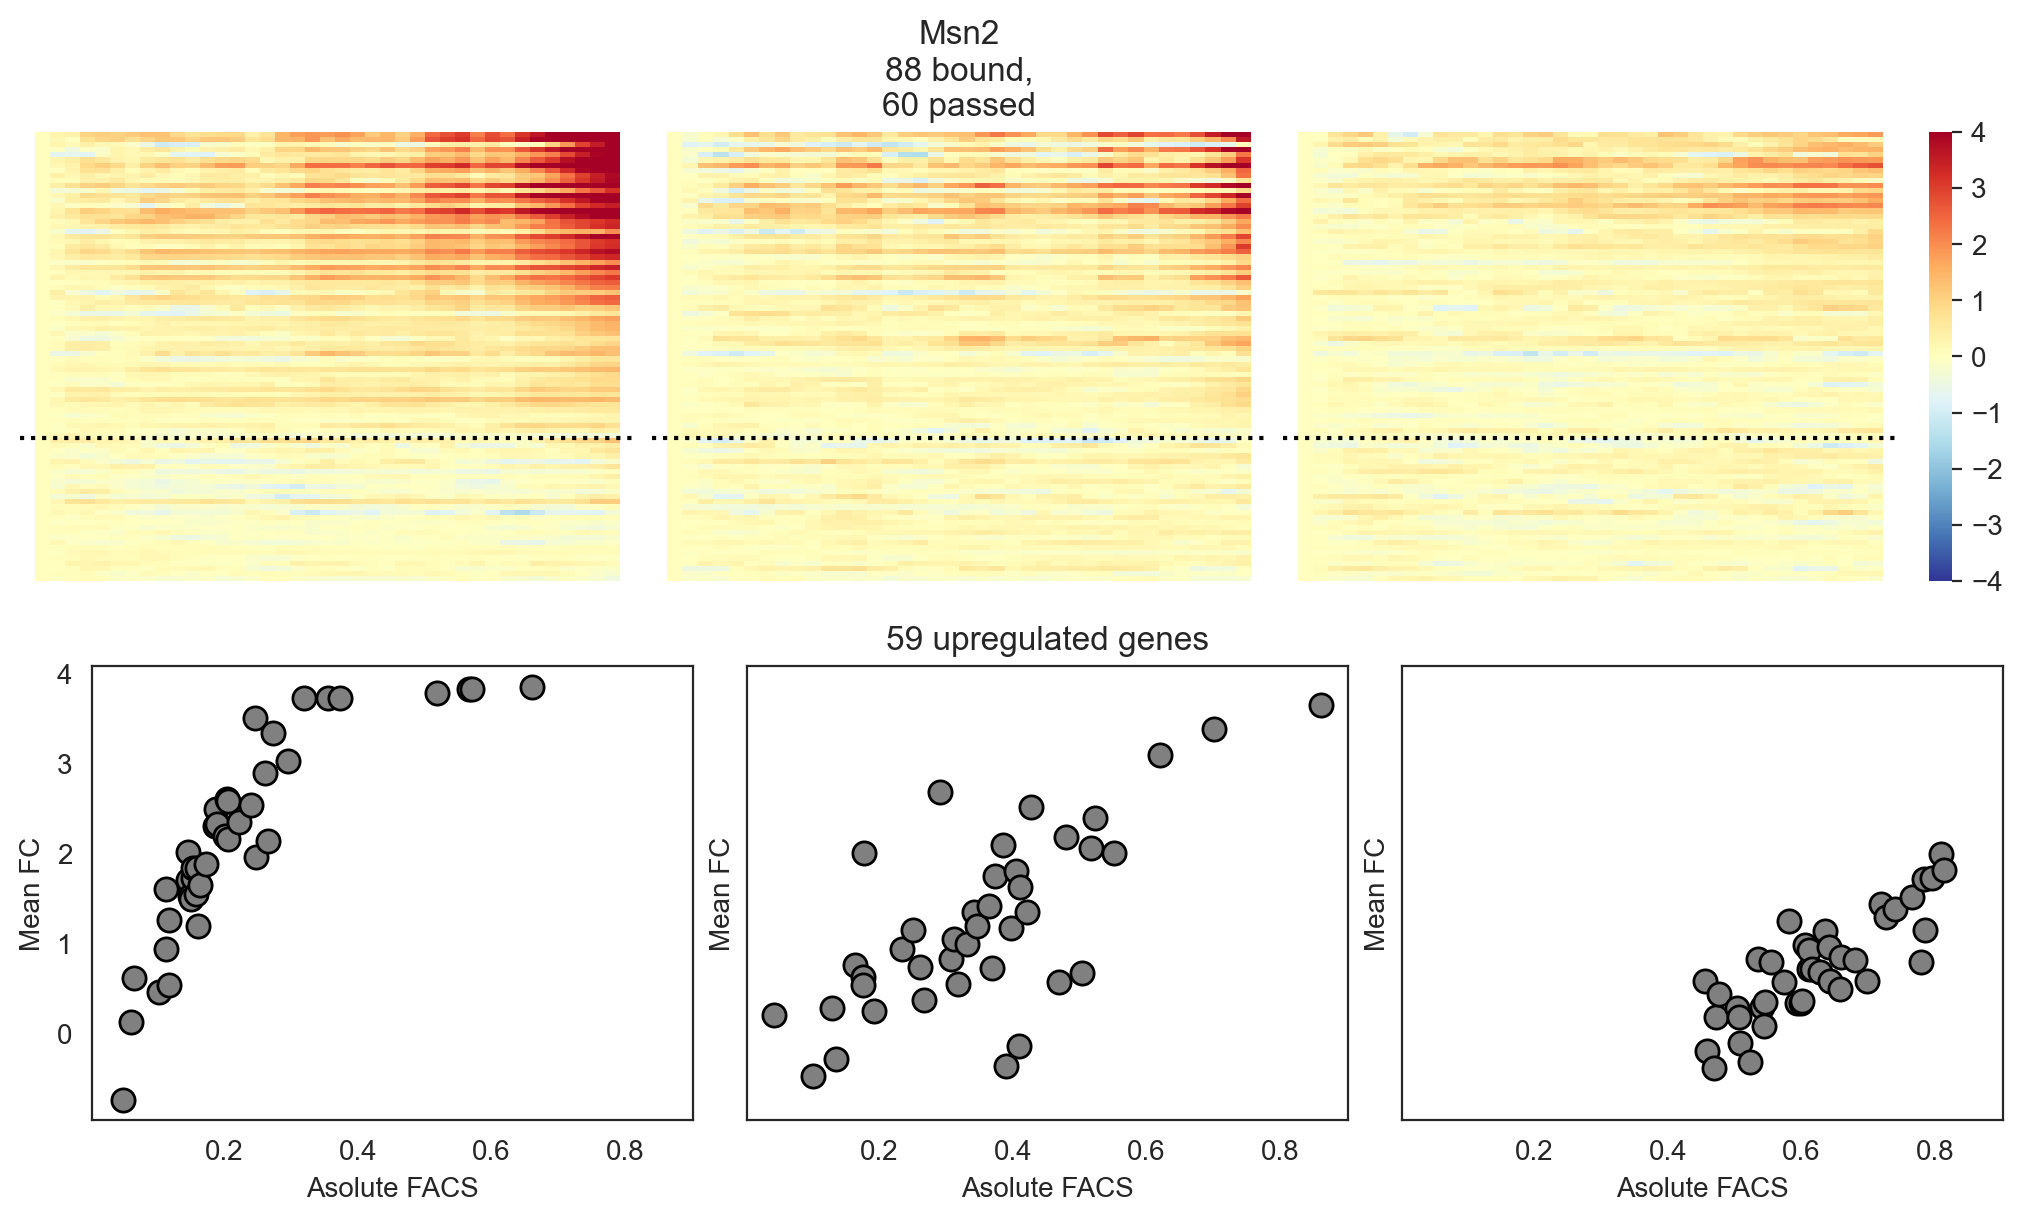

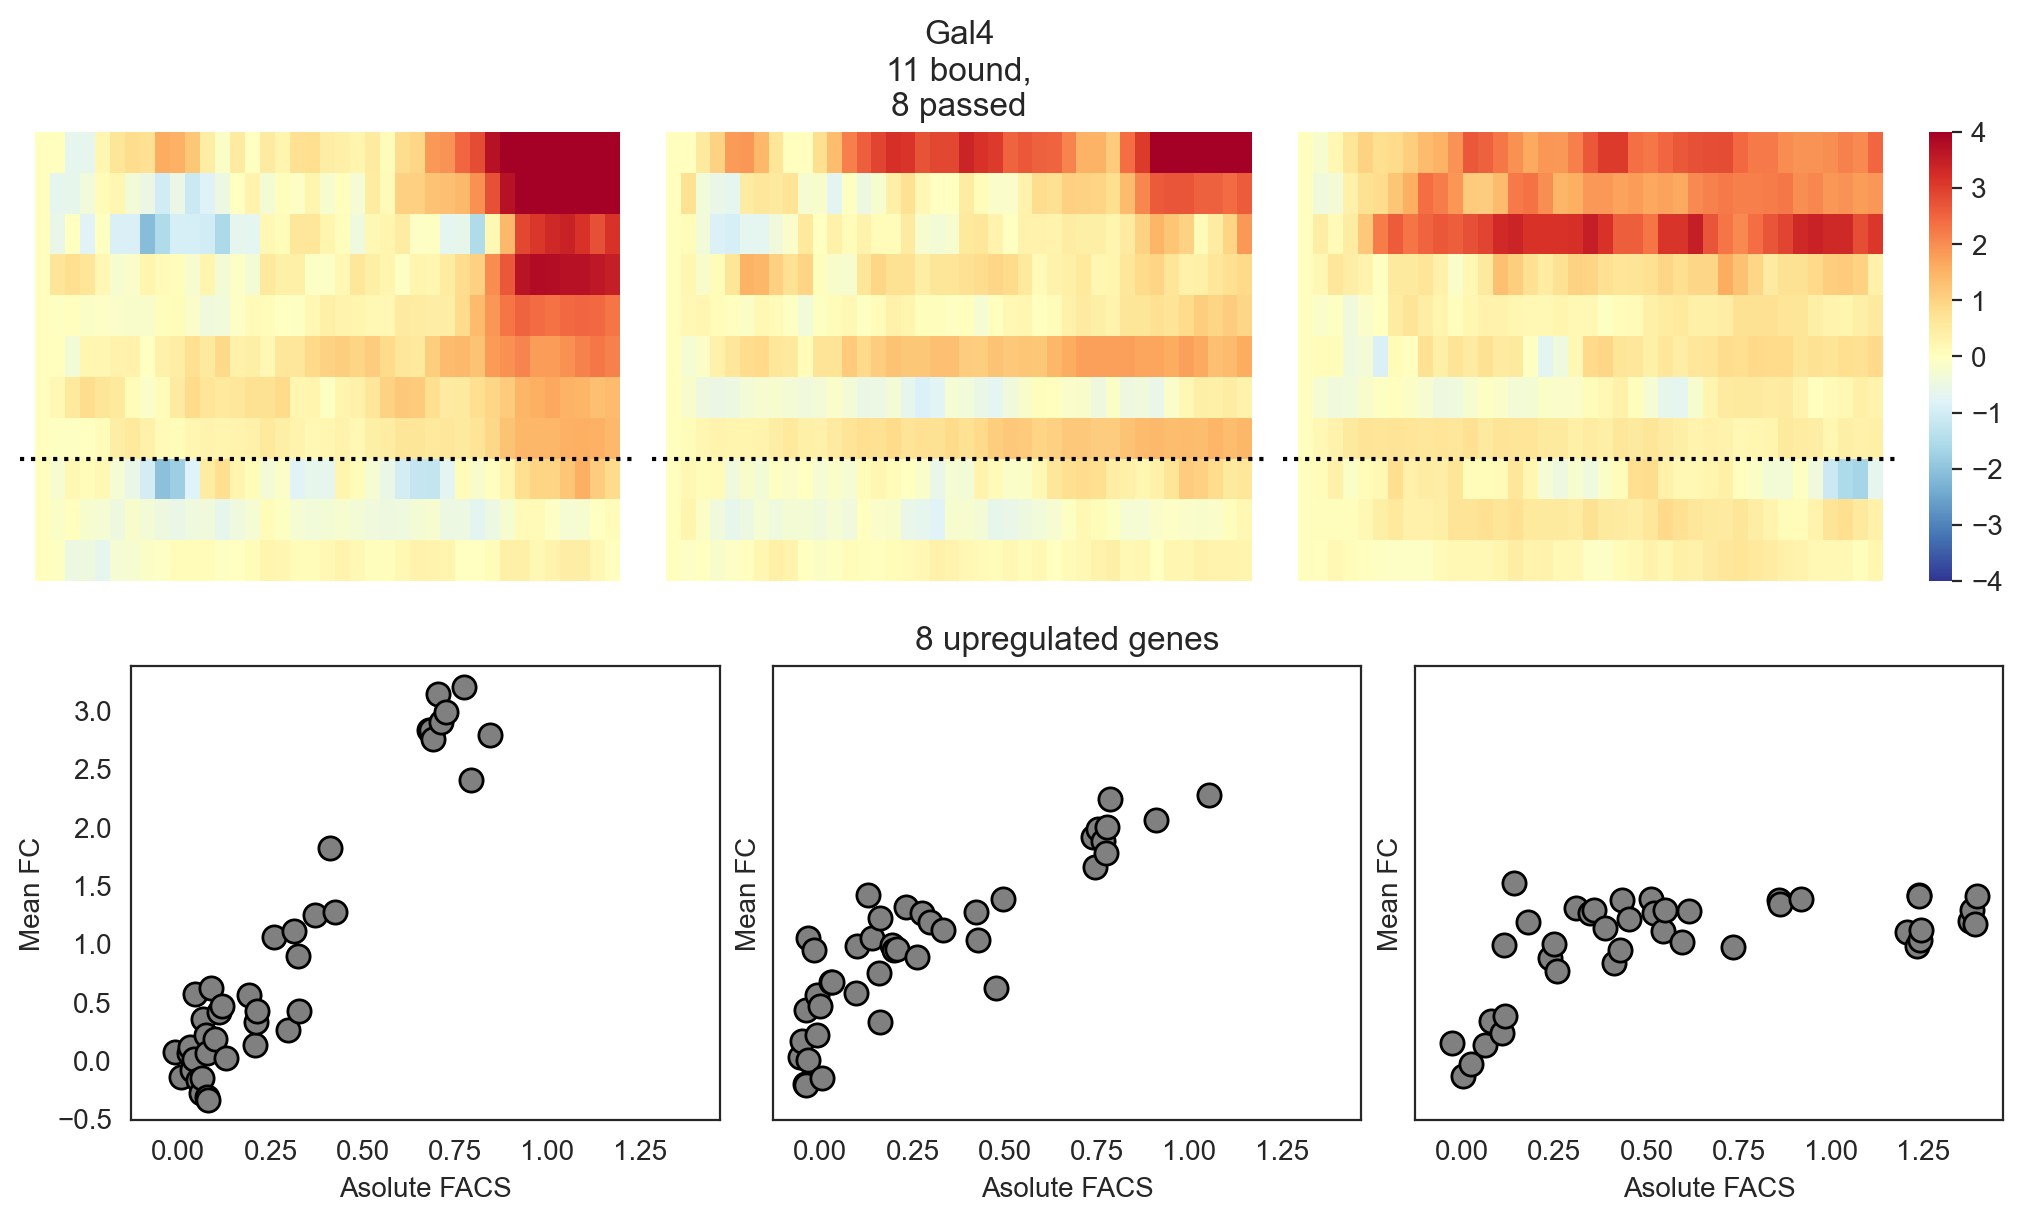

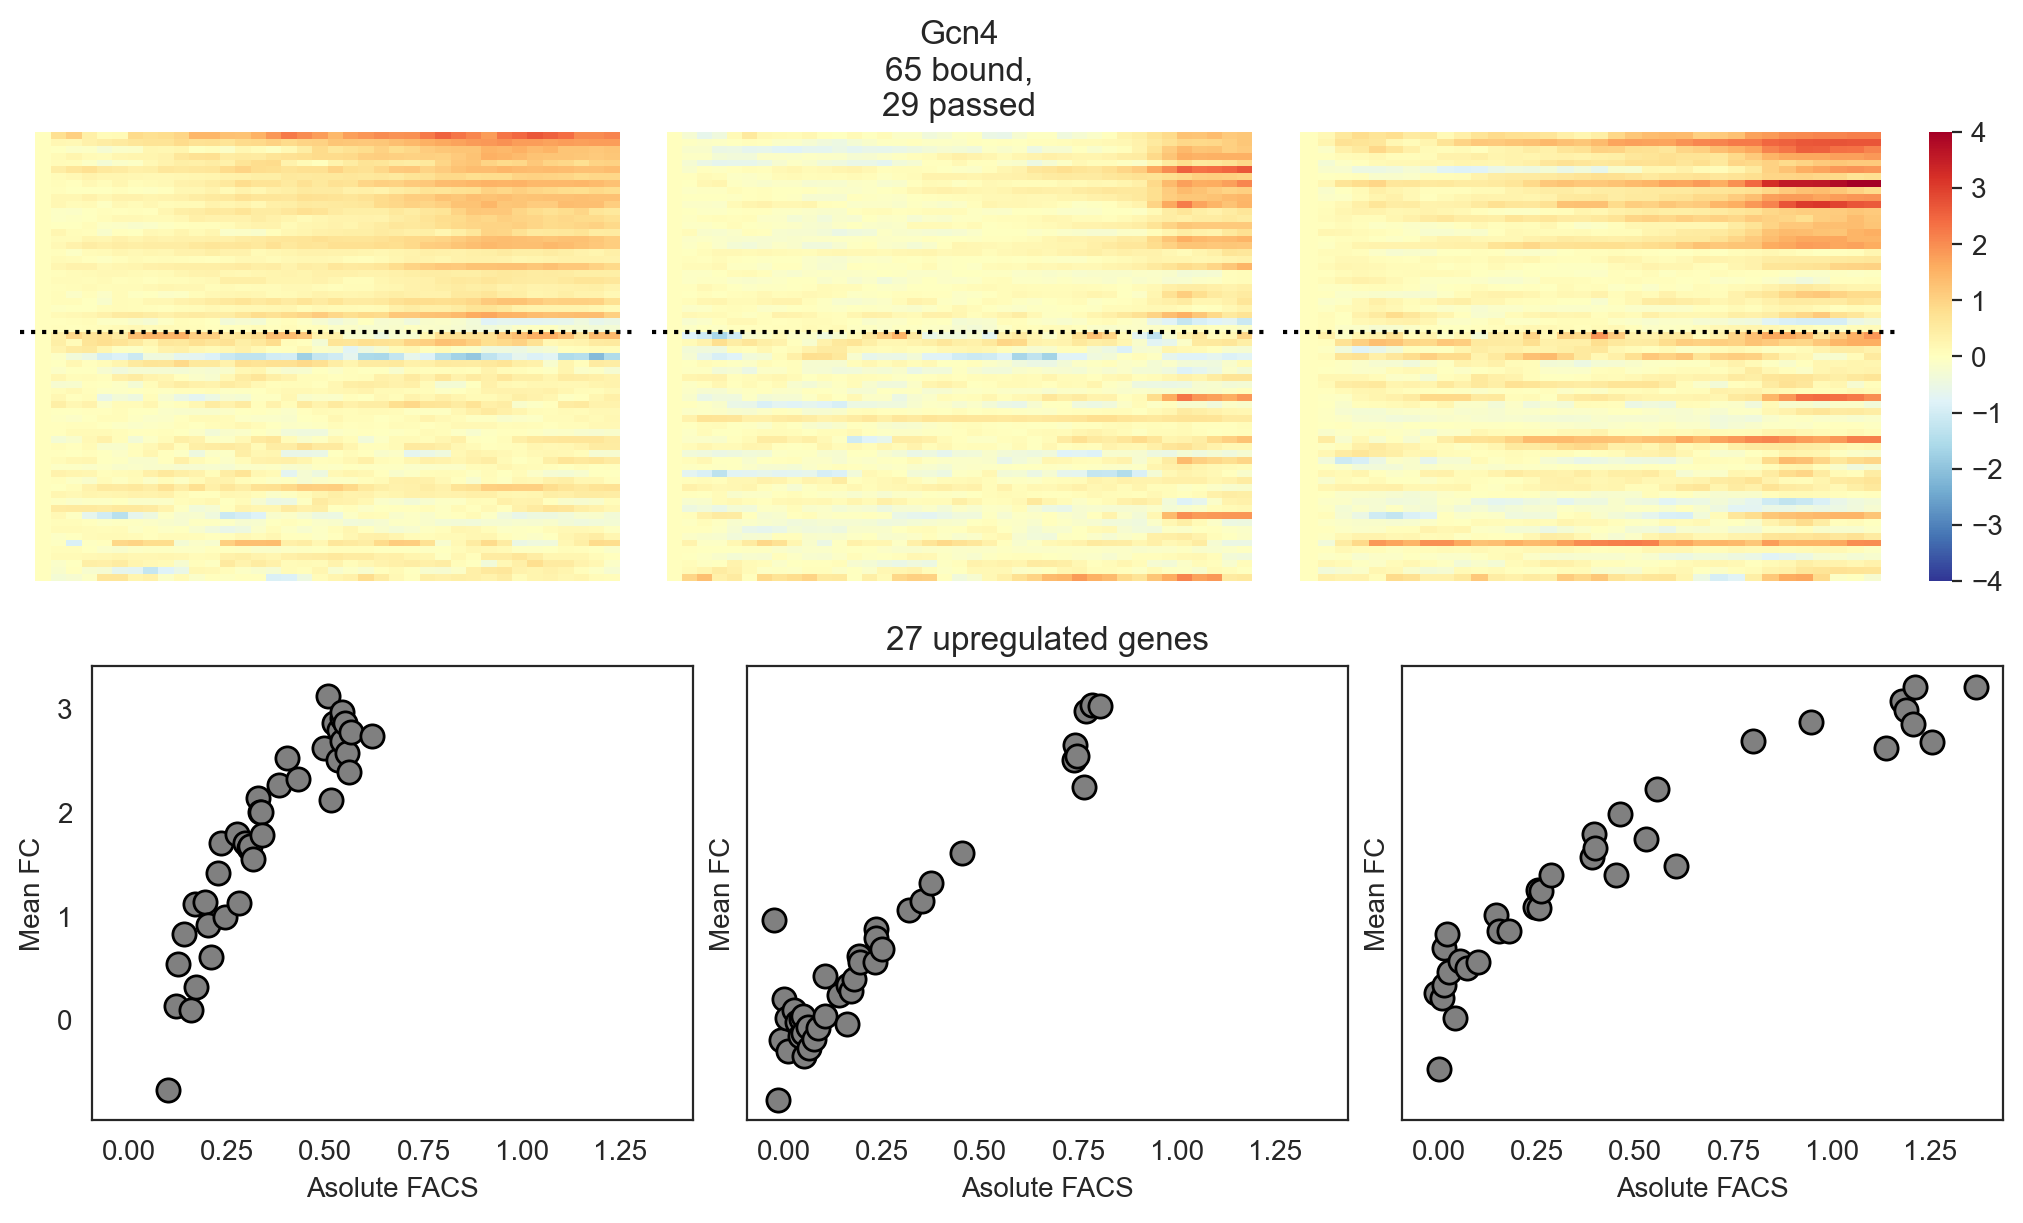

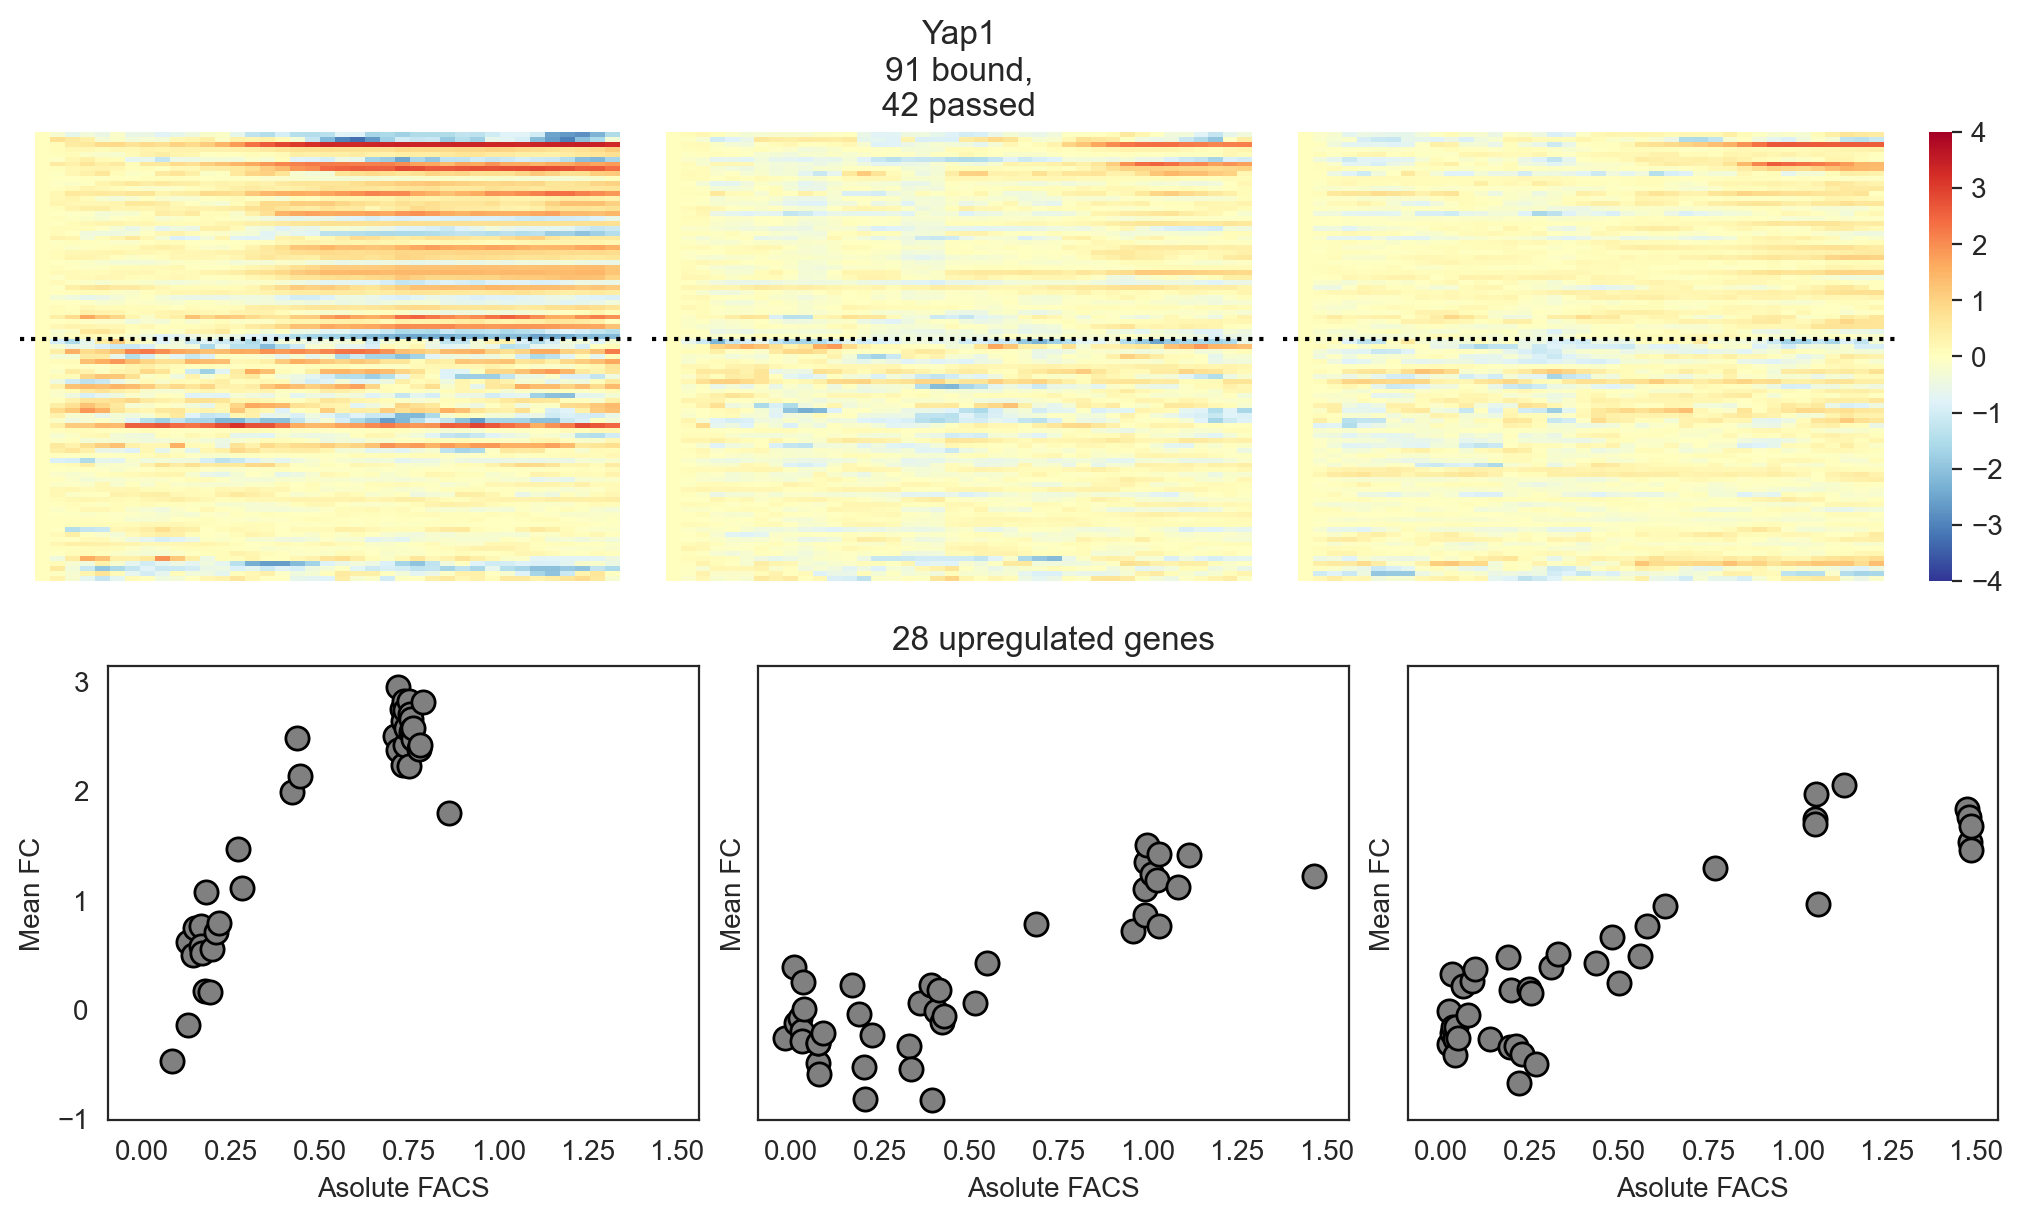

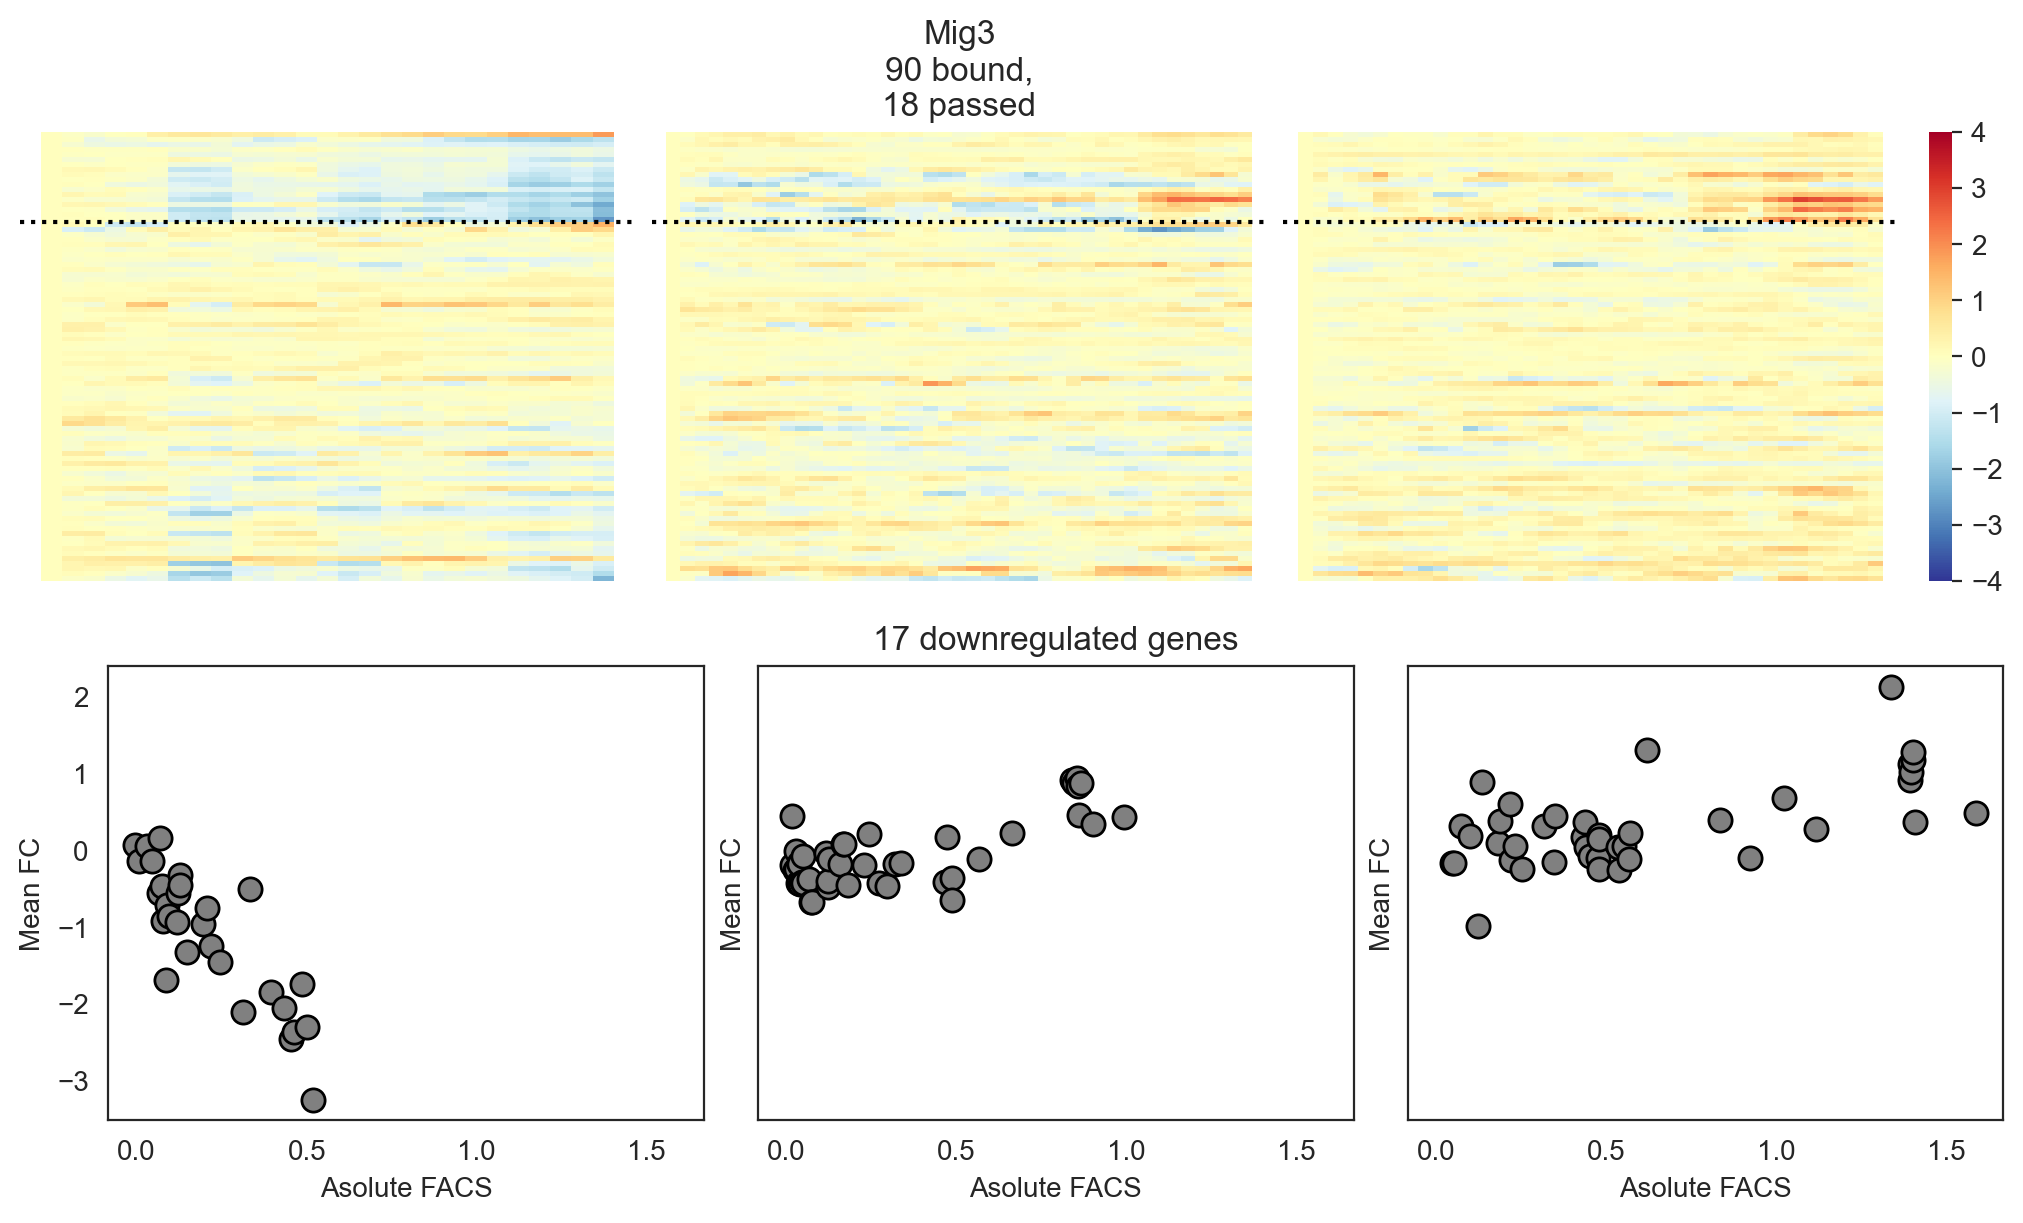

In [10]:
reload(gn)
cbar= [False, False, True]
for tf in TFS:
    direction = directions[tf]
    stats_libs_list, t, libs_list= summary_stat_d[tf]

    fig = plt.figure(figsize=(10,6), constrained_layout=True, dpi=100)
    subfigs = fig.subfigures(2,1)
    ax = subfigs[0].subplots(1,3)

    fin_order, ordered_pass, ordered_not_pass = return_gene_subset(to_subset[0], libs_list, stats_libs_list, t)
    ax[1].set_title('{}\n{} bound,\n{} passed'.format(tf, len(fin_order), len(ordered_pass)))

    a,b,c = stats_libs_list[0].copy(), stats_libs_list[1].copy(), stats_libs_list[2].copy()
    a,b,c = map(mod_df, [a,b,c], repeat(fin_order))
    
    # effected_per_d[tf] = dict(zip(['Full', 'Gal4AD', 'Gcn4AD'], map(get_effected, (a,b,c), repeat(fin_order), direction)))
    maxv, pl_dict, fc_dict_tf = create_data_forlibs_scatter(libs_list, bins, direct_targets[tf][direction[0]], fin_order, by_facs, tf)
    fc_big_d[tf] = fc_dict_tf
    
    list_norm_dat = list(map(order_and_normalize,  libs_list, repeat(fin_order), repeat(ordered_pass), repeat(ordered_not_pass)))
    plot_htmp = lambda x: htmp_libs(list_norm_dat[x], ax=ax[x], genes_passed=len(ordered_pass), cbar=cbar[x])
    
    plot_htmp(0)
    plot_htmp(1)
    plot_htmp(2)

    ax = subfigs[1].subplots(1,3, sharex=True, sharey=True, )
    targ_scatters = direct_targets[tf][direction[0]]

    fc = list()
    for i, val in enumerate(pl_dict.values()):
        sc= ax[i].scatter(val[0], val[1], c='gray' ,edgecolors='k', s=70)
        ax[i].set_ylabel('Mean FC')
        ax[i].set_xlabel('Asolute FACS')
        fc.append(val[1][-3:].mean() - val[1][:3].mean())
    effected_per_d[tf] = dict(zip(['Full', 'Gal4AD', 'Gcn4AD'], fc))

    ax[1].set_title('{} {} genes'.format(len(targ_scatters), direction[0]))
    # fig.savefig('after_gm/fig2/exp_heatmaps.pdf', bbox_inches = 'tight', transparent=True)

In [11]:
# reload(gn)
# cbar= [False, False, True]
# fig = plt.figure(figsize=(10,15), constrained_layout=True)
# subfigs = fig.subfigures(5,1)
# for tfi, tf in enumerate(TFS):
#     direction = directions[tf]
#     stats_libs_list, t, libs_list= summary_stat_d[tf]

#     ax = subfigs[tfi].subplots(1,3)

#     fin_order, ordered_pass, ordered_not_pass = return_gene_subset(to_subset[0], libs_list, stats_libs_list, t)
#     ax[1].set_title('{}\n{} bound,\n{} passed'.format(tf, len(fin_order), len(ordered_pass)))

#     a,b,c = stats_libs_list[0].copy(), stats_libs_list[1].copy(), stats_libs_list[2].copy()
#     a,b,c = map(mod_df, [a,b,c], repeat(fin_order))
    
#     maxv, pl_dict, _ = create_data_forlibs_scatter(libs_list, bins, direct_targets[tf][direction[0]], fin_order, by_facs, tf)
    
#     list_norm_dat = list(map(order_and_normalize,  libs_list, repeat(fin_order), repeat(ordered_pass), repeat(ordered_not_pass)))
#     plot_htmp = lambda x: htmp_libs(list_norm_dat[x], ax=ax[x], genes_passed=len(ordered_pass), cbar=cbar[x])
    
#     plot_htmp(0)
#     plot_htmp(1)
#     plot_htmp(2)

#     targ_scatters = direct_targets[tf][direction[0]]

#     fc = list()
    
#     for i, val in enumerate(pl_dict.values()):
#         fc.append(val[1][-3:].mean() - val[1][:3].mean())
#     effected_per_d[tf] = dict(zip(['Full', 'Gal4AD', 'Gcn4AD'], fc))

# fig.savefig('after_gm/fig2/exp_heatmaps.pdf', bbox_inches = 'tight', transparent=True)

# Fig2C part2

Text(0.5, 0.98, 'Msn2')

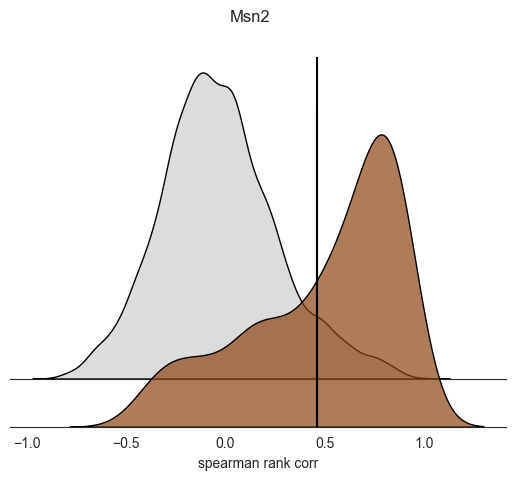

In [12]:
tef_ts = fg.get_targets_df(tfs_binding_deletions_tef ,3,'df', opn, '')
gcn4ts = tef_ts.loc['Msn2Full_dMsn2_deletions_tef_4_reps_0.99_meancorr', 'df']
fdr = np.abs(summary_stat_d['Msn2'][0][0].loc[:, ['spearman', 'fdr_corr']]).sort_values(by='spearman', ascending=False).fdr_corr
gcn4corrs = pd.DataFrame(summary_stat_d['Msn2'][0][0].spearman)

fig, ax = plt.subplots(2,1, sharex=True, sharey=True, dpi=50)
sns.kdeplot(gcn4corrs.drop(top50_msn2).transpose().values[0], ax=ax[0],
            bw_adjust=0.8, alpha=1, fill=True, color='gainsboro',linewidth=1, edgecolor='k')
sns.kdeplot(gcn4corrs.loc[top50_msn2].transpose().values[0], ax=ax[1],
            bw_adjust=0.8, alpha=.7, fill=True, color='saddlebrown',linewidth=1, edgecolor='k')

for axi in ax:
    rect = axi.patch
    rect.set_alpha(0)
    axi.set_xlabel('spearman rank corr')
    axi.set_ylabel('')
    axi.set_yticklabels('')
    axi.axvline(0.460788, c='k')
sns.despine(fig,top=True,bottom=False, left=True)


fig.subplots_adjust(hspace=-.85)
fig.suptitle('Msn2')

# fig.savefig('after_gm/fig2/corr_dist.pdf', bbox_inches = 'tight', transparent=True)

# Fig 2E

In [13]:
summary = dict()
targets_len = list()
for tf in TFS:
    d = summary_stat_d[tf][0]
    cts = tops[tf]
    targets_len.append(len(cts))
    count_perc = lambda x: d[x].loc[cts].fdr_corr.sum() / cts.shape[0]
    summary[tf] = dict(zip(['Full', 'Gal4AD', 'Gcn4AD'],
                          map(count_perc, [0,1,2])))
summary_df = pd.DataFrame(summary)

newannot = []
for i in 0,1,2:
    for k, val in enumerate((summary_df * targets_len).round().astype(int).astype(str).iloc[i,:].values):
        newannot.append('{}/{}'.format(val, targets_len[k]))
    
newannot = np.array(newannot).reshape(3,5)

Text(0.5, 1.0, 'Induced (%)')

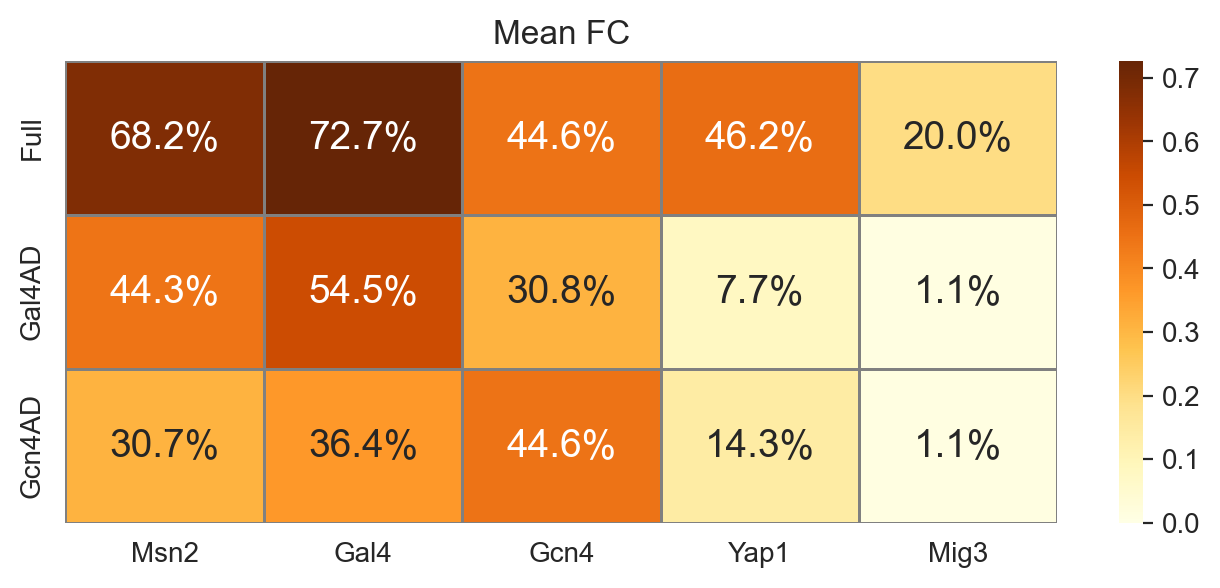

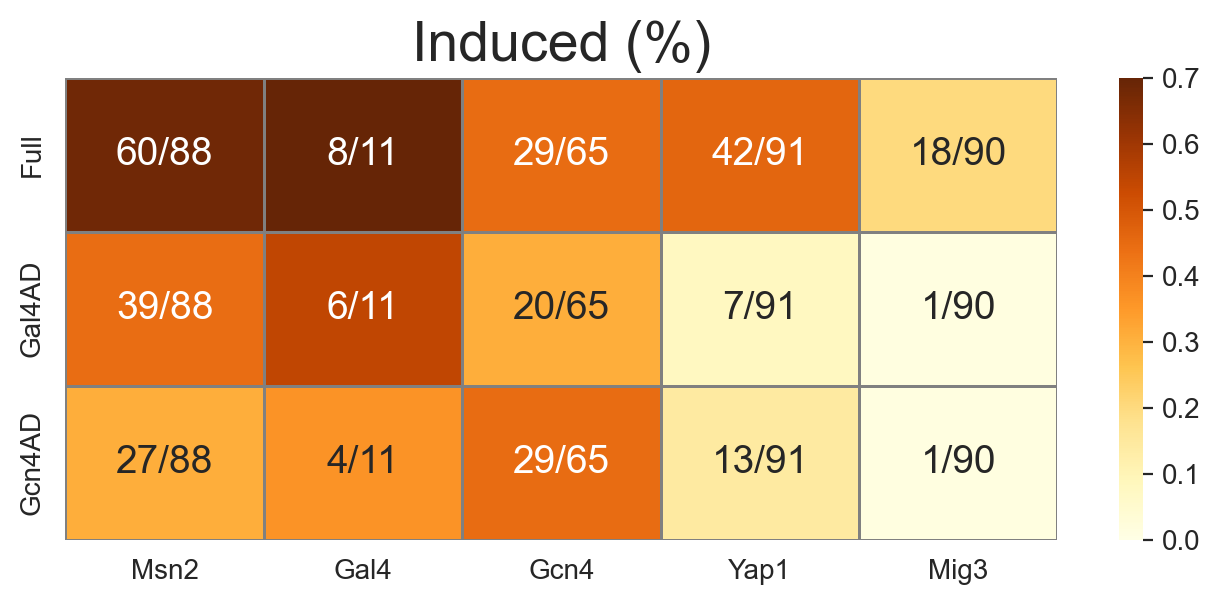

In [14]:
fig, ax = plt.subplots(1, figsize=(8,3), dpi=100)
sns.heatmap(summary_df, cmap='YlOrBr', annot=True, fmt='.1%', ax=ax,
            cbar=True,annot_kws={"size": 14}, linecolor='gray', linewidths=1, vmin=0)
plt.title('Mean FC')
# fig.savefig('newtext_figs/fig2/corr_summary.pdf', bbox_inches = 'tight', transparent=True)

fig, ax = plt.subplots(1, figsize=(8,3), dpi=100)
sns.heatmap(summary_df, cmap='YlOrBr', annot=newannot, fmt='', ax=ax,
            cbar=True,annot_kws={"size": 14}, linecolor='gray', linewidths=1, vmin=0, vmax=.7)
plt.title('Induced (%)', size=20)
# fig.savefig('newtext_figs/fig2/corr_summary_numbers.pdf', bbox_inches = 'tight', transparent=True)

# Fig2F + Supp

Text(0.5, 1.0, 'Mean FC')

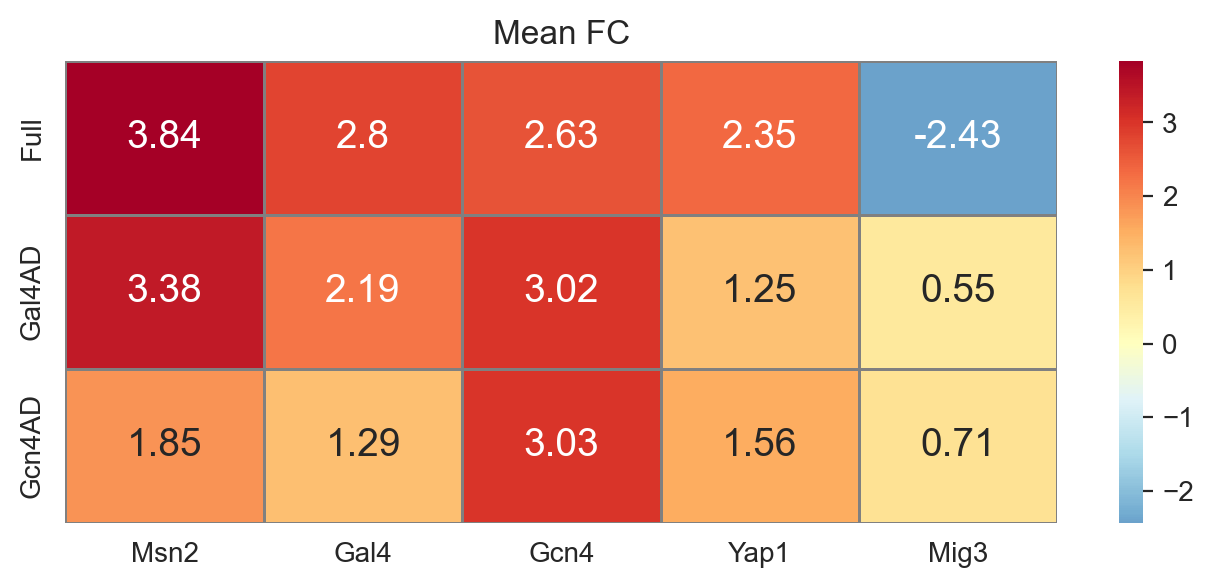

In [15]:
fc_df = pd.DataFrame(effected_per_d).round(2)
fc_df.index = ['Full', 'Gal4AD', 'Gcn4AD']

fig, ax = plt.subplots(1, figsize=(8,3), dpi=100)
sns.heatmap(fc_df, cmap='RdYlBu_r', annot=True, fmt='', ax=ax, center=0,
            cbar=True,annot_kws={"size": 14}, linecolor='gray', linewidths=1)
plt.title('Mean FC')
# fig.savefig('newtext_figs/fig2/fc_summary.pdf', bbox_inches = 'tight', transparent=True)

# Figure 2D

In [16]:
d = defaultdict(dict)
neededgenes=pd.Index(list(direct_targets['Gal4']['upregulated']) +\
                     list(direct_targets['Gcn4']['upregulated'])+\
                     list(direct_targets['Msn2']['upregulated'])+\
                     list(direct_targets['Mig3']['downregulated'])+\
                     list(direct_targets['Yap1']['upregulated'])).drop_duplicates()

for tf in ['Gal4', 'Gcn4', 'Msn2', 'Yap1', 'Mig3']:
    for i in ['Full', 'Gal4AD', 'Gcn4AD']:
        
        curr_facs = rna_libs.filter(regex='^'+tf).filter(regex=i).loc['facs'].sub(by_facs[tf][i]).values
        val_list = []
        for target in neededgenes:
            curr_vec = rna_libs.filter(regex='^'+tf).filter(regex=i).loc[target].values
            val_list.append(get_corr_gene(curr_facs, curr_vec)[0])
        if 'AD' in i:
            d[tf][tf+'DBD'+i] = val_list
        else:
            d[tf][tf+i] = val_list
            
corr_df = pd.concat([pd.DataFrame.from_dict(d['Gal4']),
                     pd.DataFrame.from_dict(d['Gcn4']),
                     pd.DataFrame.from_dict(d['Msn2']),
                     pd.DataFrame.from_dict(d['Yap1']),
                     pd.DataFrame.from_dict(d['Mig3'])], axis=1)
corr_df.index = neededgenes

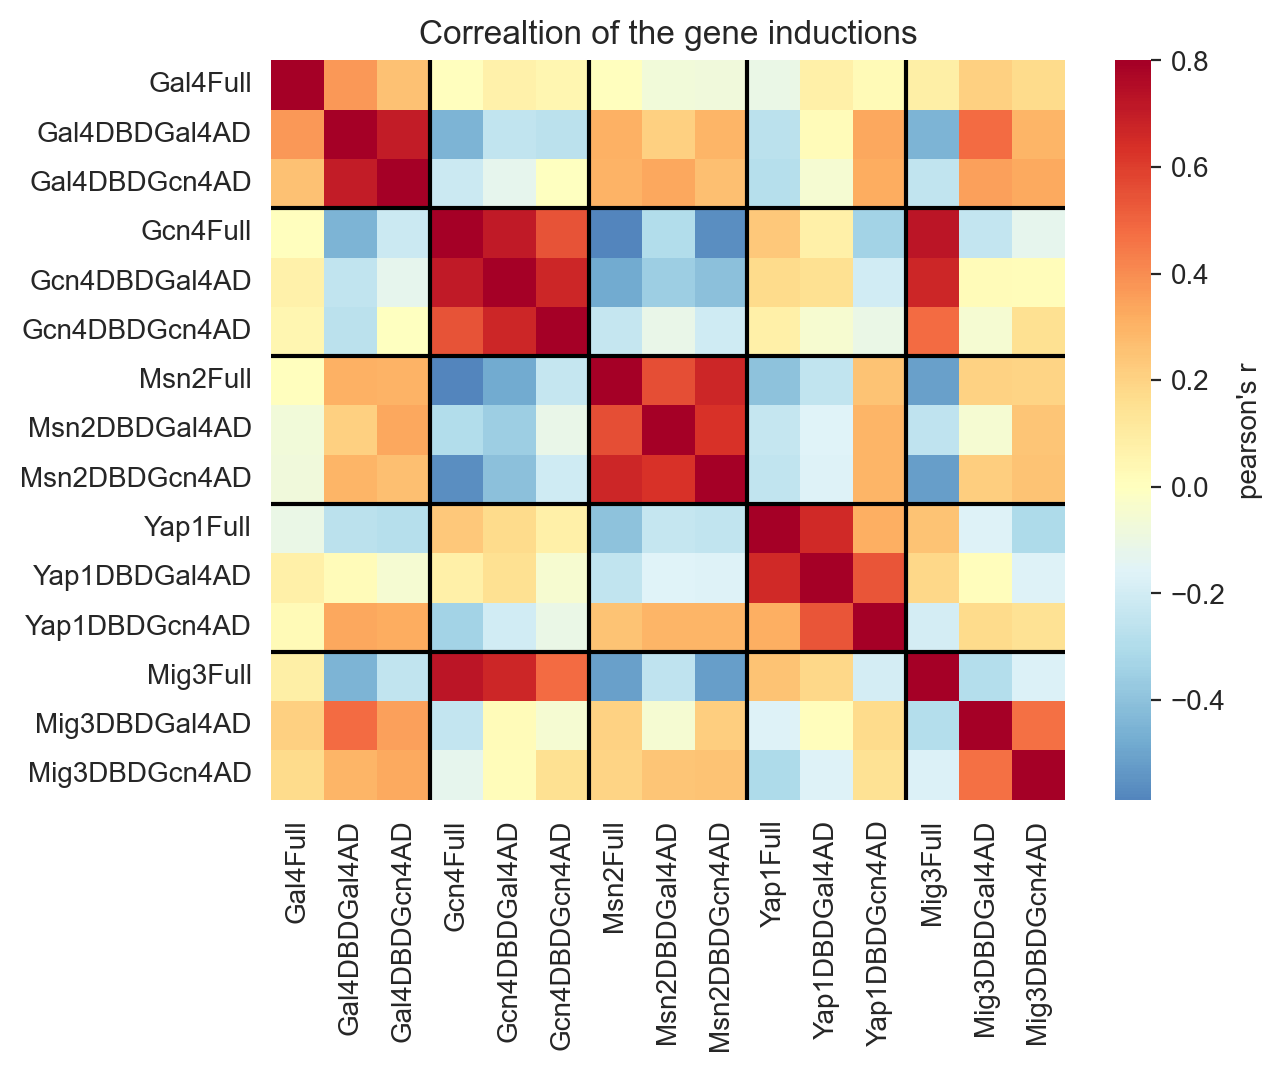

In [17]:
fig, ax = plt.subplots(1)
sns.heatmap(corr_df.corr(), cmap = 'RdYlBu_r', vmax=0.8, center=0, annot=False, ax=ax, cbar_kws={'label':'pearson\'s r'})
ax.set_title('Correaltion of the gene inductions')
for i in [3,6,9,12]:
    ax.axvline(i,c='k')
    ax.axhline(i,c='k')

# fig.savefig('newtext_figs/fig2/corr_libs.pdf', bbox_inches = 'tight')


# Fig2B

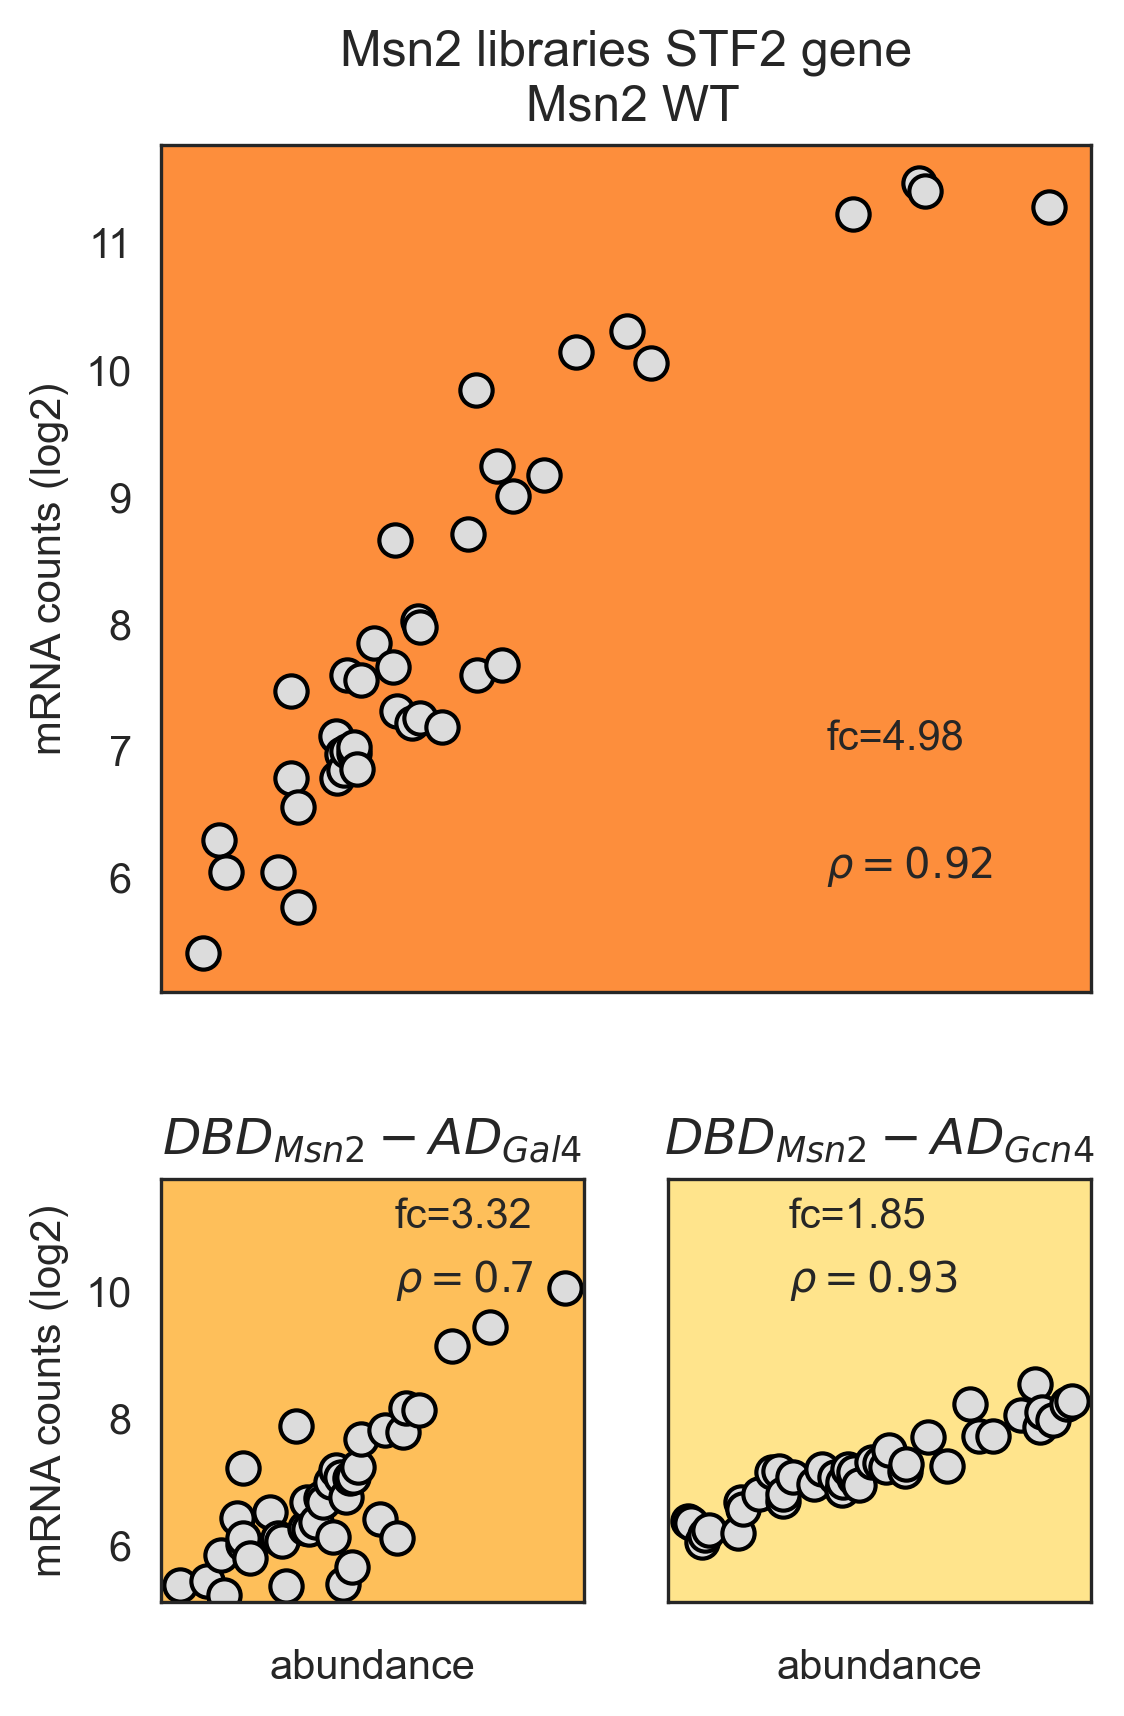

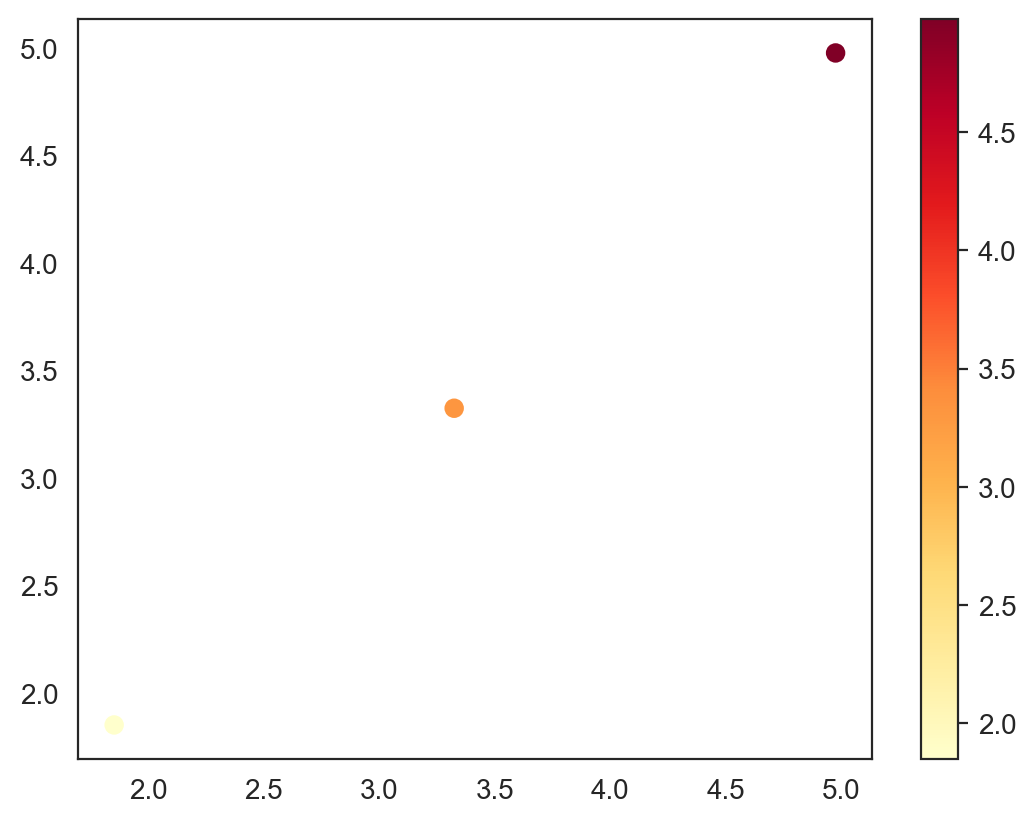

In [18]:
fcs = list()
gene= 'STF2'
msn2libs = summary_stat_d['Msn2'][2]
ed_cl = 'k'
cmap = sns.color_palette('YlOrRd', as_cmap=True)
norm = mpl.colors.Normalize(vmin=0, vmax=10)
c = 'gainsboro'
s = 60

fig = plt.figure(figsize=(4,5.5), dpi=150)
subfigs = fig.subfigures(2,1, height_ratios=[2,1])
ax = subfigs[0].subplots(1)
ax.scatter(msn2libs[0].loc['facs', :]-by_facs_df.loc['Full', 'Msn2'], msn2libs[0].loc[gene,:], edgecolors=ed_cl,c=c,s=s)
ax.text(0.5,6,r'$\rho={}$'.format(np.round(summary_stat_d['Msn2'][0][0].loc[gene,'spearman'],2)))

fc = msn2libs[0].loc[gene,:].iloc[-5:].mean() - msn2libs[0].loc[gene,:].iloc[:5].mean()
fcs.append(fc)
ax.text(0.5,7, 'fc={}'.format(np.round(fc,2)))
ax.set_facecolor(cmap(norm(fc)))
ax.set_title('Msn2 libraries STF2 gene\n Msn2 WT')
ax.set_xticklabels('')
ax.set_ylabel('mRNA counts (log2)')

ylim = ax.get_ylim()

ax = subfigs[1].subplots(1,2, sharey=True)
ax=ax.flatten()

ax[0].scatter(msn2libs[1].loc['facs', :]-by_facs_df.loc['Gal4AD', 'Msn2'], msn2libs[1].loc[gene,:], edgecolors=ed_cl,c=c,s=s)
ax[0].text(0.5,10,r'$\rho={}$'.format(np.round(summary_stat_d['Msn2'][0][1].loc[gene,'spearman'],2)))
fc = msn2libs[1].loc[gene,:].iloc[-5:].mean() - msn2libs[1].loc[gene,:].iloc[:5].mean()
fcs.append(fc)

ax[0].set_facecolor(cmap(norm(fc)))
ax[0].text(0.5,11, 'fc={}'.format(np.round(fc,2)))
ax[0].set_title(r'$DBD_{Msn2}-AD_{Gal4}$')

ax[1].scatter(msn2libs[2].loc['facs', :]-by_facs_df.loc['Gcn4AD', 'Msn2'], msn2libs[2].loc[gene,:], edgecolors=ed_cl, c=c,s=s)
ax[1].text(0.55,10,r'$\rho={}$'.format(np.round(summary_stat_d['Msn2'][0][2].loc[gene,'spearman'],2)))
fc = msn2libs[2].loc[gene,:].iloc[-5:].mean() - msn2libs[2].loc[gene,:].iloc[:5].mean()
fcs.append(fc)

ax[1].set_facecolor(cmap(norm(fc)))
ax[1].text(0.55,11, 'fc={}'.format(np.round(fc,2)))
ax[1].set_title(r'$DBD_{Msn2}-AD_{Gcn4}$')
for axi in ax:
    axi.set_ylim(ylim)
    axi.set_xticklabels('')
    axi.set_xlabel('abundance')
ax[0].set_ylabel('mRNA counts (log2)')

# fig.savefig('after_gm/fig2/scatters.pdf', bbox_inches = 'tight')


fig, ax = plt.subplots(1)
s = ax.scatter(fcs, fcs, c=fcs, cmap=cmap)
fig.colorbar(s)
# fig.savefig('after_gm/fig2/cbar_for_scat.pdf', bbox_inches = 'tight')
